# Mining Data Streams

In this lab, we are supposed to pick a dataset and a paper. 

## Dataset
We use the [Google Webgraph dataset](https://snap.stanford.edu/data/web-Google.html). Potential caveat that it contains *directed* edges. 

| **Property** | **Value** |
| --- | --- |
| Nodes | 875713          |
| Edges | 5105039         |
| Nodes in largest WCC | 855802 (0.977)  |
| Edges in largest WCC | 5066842 (0.993) |
| Nodes in largest SCC | 434818 (0.497)  |
| Edges in largest SCC | 3419124 (0.670) |
| Average clustering coefficient   | 0.5143          |
| Number of triangles              | 13391903        |
| Fraction of closed triangles     | 0.01911         |
| Diameter (longest shortest path) | 21              |
| 90-percentile effective diameter | 8.1             |

## Paper
* ~~We chose the algorithm in the paper [A Space-Efficient Streaming Algorithm for Estimating Transitivity and Triangle Counts Using the Birthday Paradox](https://arxiv.org/pdf/1212.2264.pdf) by M. Jha, C. Seshadhri, and A. Pinar.~~
* Second thought, how about no. Terrible psuedocode made us turn to [TRIÈST: Counting Local and Global Triangles in
Fully-Dynamic Streams with Fixed Memory Size](https://www.kdd.org/kdd2016/papers/files/rfp0465-de-stefaniA.pdf)

### How to run this Notebook with Docker
If you want to run this Notebook with Docker, the Jupyter team has several images over at ... . In the [documentation](https://jupyter-docker-stacks.readthedocs.io/en/latest/index.html) they show an example:

```bash
docker run -p 10000:8888 jupyter/pyspark-notebook:latest
```

> Visiting `http://<hostname>:10000/?token=<token>` in a browser loads JupyterLab, where `<hostname> = 0.0.0.0` and token is generated in the terminal.

In [4]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("lab3").getOrCreate()
spark.sparkContext.setLogLevel("WARN")
spark

In [20]:
NUMBER_OF_TRIANGLES = 13391903

In [5]:
# read a csv file with pyspark
rdd = spark.read.option("delimiter", "\t").csv("../../data/web-Google.txt", header=True, inferSchema=True)

In [6]:
# show df schema
rdd.show(5)

+----------+--------+
|FromNodeId|ToNodeId|
+----------+--------+
|         0|   11342|
|         0|  824020|
|         0|  867923|
|         0|  891835|
|     11342|       0|
+----------+--------+
only showing top 5 rows



I don't know how to simulate a stream properly, so I'll convert the rdd to a Panda's dataframe, and iterate over each row 🤷🏻‍♂️

In [7]:
import pandas as pd
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df = rdd.toPandas()
stream = []
for index, row in df.iterrows():
    edge = (row[0], row[1])
    stream.append(edge)

In order to maintain a subgraph, we implement a `Graph` class which  simulates an undirected graph and holds all edges in an adjacency list. Since we are calling the `neighbors` method a lot, keeping them in an adjency list is more efficient than iterating over the whole list of edges. 

In [8]:
from collections import defaultdict
import random

class Graph:
    """
    A graph object to simplify the implementation of the algorithm
    """
    def __init__(self):
        self.adj_list = defaultdict(set)
        self.edges = 0
    
    def add_edge(self, edge):
        u, v = edge
        self.adj_list[u].add(v)
        self.adj_list[v].add(u)
        self.edges = self.edges + 1
    
    def remove_edge(self, edge):
        u, v = edge
        # remove edge from all neighbors
        self.adj_list[u].remove(v)
        self.adj_list[v].remove(u)
        # the paper says to remove the vertex if it has no neighbors
        self.prune_empty_vertices(edge)
        self.edges = self.edges - 1
    
    def prune_empty_vertices(self, edge):
        u, v = edge
        # adjacency list empty -> remove vertex
        if len(self.adj_list[u]) == 0:
            del self.adj_list[u]
        if len(self.adj_list[v]) == 0:
            del self.adj_list[v]

    def neighbors(self, edge):
        u, v = edge
        # since the edge might come from the stream, we need to check if it is in the graph.
        # If it is not, we return an empty set, else we return the adjecency list of respective vertex
        if u not in self.adj_list or v not in self.adj_list:
            return set()
        else:
            return self.adj_list[u] & self.adj_list[v]
    
    def yield_random_edge(self):
        # pick a random vertex from the graph
        x = random.choice(list(self.adj_list))
        # pick a random neighbor, vertex y, of x
        y = random.choice(list(self.adj_list[x]))
        return (x, y)

Parameters in the paper:

* Our algorithms keep an edge sample $\mathcal{S}$ of up to $M$ edges from the stream (as contrary to sampling with a probability $p$)

* Trièst algorithms keep counters to compute the estimations of the global and local number of triangles. They always keep one global counter $\tau$ for the estimation of the global number of triangles.

* For any t ≥ 0, let $G^S = (V^S, E^S)$ be the subgraph of $G(t)$ containing all and only the edges in the currentsample $\mathcal{S}$. We denote with $\mathcal{N}^S_u$ the neighborhood of $u$ in $G^S: \mathcal{N}^S_u = \{v ∈ V^{(t)}: (u, v) ∈ \mathcal{S}\}$ and with $\mathcal{N}^\mathcal{S}_{u, v} = \mathcal{N}^\mathcal{S}_u \cap \mathcal{N}^\mathcal{S}_v$ the shared neighborhood of $u$ and $v$ in $G^\mathcal{S}$

In [9]:
import numpy as np
from random import sample
from operator import add, sub

class TriestBase:
    # set up nasty globals >_<
    def __init__(self, stream, M=6):
        self.stream = stream
        self.tau = defaultdict(int)
        # TODO borde S vara en adjecency list?
        self.S = Graph()
        self.t = 0
        self.M = M

    def run(self):
        # Here I simulate a stream of edges
        for edge in self.stream:
            self.t+=1
            if self.sample_edge(edge):
                self.S.add_edge(edge)
                self.update_counters(operator=add, edge=edge)

    def sample_edge(self, edge):
        if self.t <= self.M:
            return True
        elif self.flip_biased_coin(self.M/self.t):
            # pick a random edge from S
            random_edge = self.S.yield_random_edge()
            # remove it from S
            self.S.remove_edge(random_edge)
            self.update_counters(operator=sub, edge=random_edge)
            return True
        else:
            return False

    def flip_biased_coin(self, p):
        # TODO is olikheten correct or should it be '>'?
        return np.random.rand() < p

    def update_counters(self, operator, edge):
        u, v = edge
        neighborhood = self.S.neighbors(edge)
        for c in neighborhood:
            # bug here, the operator is malfunctioning???
            self.tau['global'] = operator(self.tau['global'], 1)
            self.tau[c] = operator(self.tau[c], 1)
            self.tau[u] = operator(self.tau[u], 1)
            self.tau[v] = operator(self.tau[v], 1)
    
    def xi(self, t, M):
        f = lambda x: x * (x-1) * (x-2)
        candidate = f(t) / f(M)
        print(f"t: {t}, M: {M}, tau: {self.tau['global']}")
        print(f"f(t): {f(t)}, f(M): {f(M)}")
        print(f"candidate f(t)/f(M): {candidate}")
        return np.max([1.0, candidate])
    
    def global_estimate(self):
        return self.xi(self.t, self.M) * self.tau['global']


In [54]:
tb = TriestBase(stream, M=40000)
tb.run()

In [58]:
estimate = int(tb.global_estimate())
print(f"estimate: {estimate}")
print(f"actual: {NUMBER_OF_TRIANGLES}")
print(f"error: {int(estimate/NUMBER_OF_TRIANGLES)}%")

t: 5105039, M: 40000, tau: 75559
f(t): 133044503603959809834, f(M): 63995200080000
candidate f(t)/f(M): 2078976.2894348593
estimate: 157085369453
actual: 13391903
error: 11729%


Not even close to the real number, but it works. Probably alot better for smaller networks.


## Triéste Improved

The pseudocode for the improved version of Triéste is found in [the full paper](https://arxiv.org/pdf/1602.07424.pdf), found on Arxiv.

Changes:

* `update_counters` is called for every edge in the stream, not just the ones in the sample
* `update_counters` is modified and using $\eta$ instead of operators $+$ or $-$ for each update.

In [16]:
import numpy as np
from random import sample
from operator import add, sub

class TriestImproved:
    # set up nasty globals >_<
    def __init__(self, stream, M=6):
        # TODO antagligen krånglar det pga google-grafen är en directed graph
        self.stream = stream
        # defaultdict avoids missing key errors, and with 'int' it defaults to 0
        self.tau = defaultdict(int)
        self.S = Graph()
        self.t = 0
        self.M = M

    def run(self):
        # Here I simulate a stream of edges
        for edge in self.stream:
            self.t+=1
            # NOTE modified from BASE
            self.update_counters(edge)
            if self.sample_edge(edge):
                self.S.add_edge(edge)

    def sample_edge(self, edge):
        if self.t <= self.M:
            return True
        elif self.flip_biased_coin(self.M/self.t):
            # pick a random edge from S
            random_edge = self.S.yield_random_edge()
            # remove it from S
            self.S.remove_edge(random_edge)
            return True
        else:
            return False

    def flip_biased_coin(self, p):
        return np.random.rand() < p

    def update_counters(self, edge):
        # NOTE modified from BASE
        u, v = edge
        neighborhood = self.S.neighbors(edge)
        # define f as in the paper
        f = lambda t, M: (t-1) * (t-2) / (M*(M-1))
        # find the maximum of f(t, M) and 1
        eta = np.max([1.0, f(self.t, self.M)])
        for c in neighborhood:
            self.tau['global'] += eta
            self.tau[c] += eta
            self.tau[u] += eta
            self.tau[v] += eta
    
    def global_estimate(self):
        # NOTE modified from BASE, according to 4.2.1 in the full paper
        print(f"t: {self.t}, M: {self.M}, tau: {self.tau['global']}")
        return int(self.tau['global'])

From the paper:

> These results show that trièst-impr is very accurate even when storing **less than a 0.001 fraction of the total edges of the graph**

In [39]:
M = int(len(stream)*0.001)
print(f"M: {M}")
tb = TriestImproved(stream, M=M)
tb.run()

M: 5105


In [53]:
estimate = tb.global_estimate()
print(f"Global estimate: {estimate} vs. actual: {NUMBER_OF_TRIANGLES}")
print(f"Error: {abs(estimate - NUMBER_OF_TRIANGLES)}")

t: 5105039, M: 5105, tau: 24139412.554164883
Global estimate: 24139412 vs. actual: 13391903
Error: 10747509


# Performance

Let's get som statistics on the performance of the algorithm. To evauluate our implementation, we run it 100 times on the same dataset with $M = 1000$.

In [41]:
%%cache

"""
NOTE this cell is cached, so it will not be executed when you run the notebook.
"""

# safety switch, it took 80 minutes to run :(
execute_cell = False

if execute_cell:
    M = 1000
    print(f"M: {M}")
    number_of_runs = 100
    runs = []
    for i in range(number_of_runs):
        ti = TriestImproved(stream, M=M)
        ti.run()
        runs.append(ti.global_estimate())

M: 1000
t: 5105039, M: 1000, tau: 38783498.56918919
t: 5105039, M: 1000, tau: 19644376.50867267
t: 5105039, M: 1000, tau: 29912869.98375576
t: 5105039, M: 1000, tau: 39183380.91688288
t: 5105039, M: 1000, tau: 33366588.020834833
t: 5105039, M: 1000, tau: 32048645.603205208
t: 5105039, M: 1000, tau: 11260865.234274274
t: 5105039, M: 1000, tau: 22271474.449971974
t: 5105039, M: 1000, tau: 34714954.01325525
t: 5105039, M: 1000, tau: 47620577.3661001
t: 5105039, M: 1000, tau: 22078304.237095095
t: 5105039, M: 1000, tau: 9929910.679933934
t: 5105039, M: 1000, tau: 33399918.999307305
t: 5105039, M: 1000, tau: 26869649.566590592
t: 5105039, M: 1000, tau: 27670031.63500901
t: 5105039, M: 1000, tau: 14289598.874176174
t: 5105039, M: 1000, tau: 15637802.971163165
t: 5105039, M: 1000, tau: 10898432.447173173
t: 5105039, M: 1000, tau: 15976355.344226228
t: 5105039, M: 1000, tau: 34127741.09930931
t: 5105039, M: 1000, tau: 21837438.932784785
t: 5105039, M: 1000, tau: 24774385.96235435
t: 5105039, M

 To get a sense of how the runs are distributed, the result is presented as a violin plot, compared to the actual number of triangles in the graph.

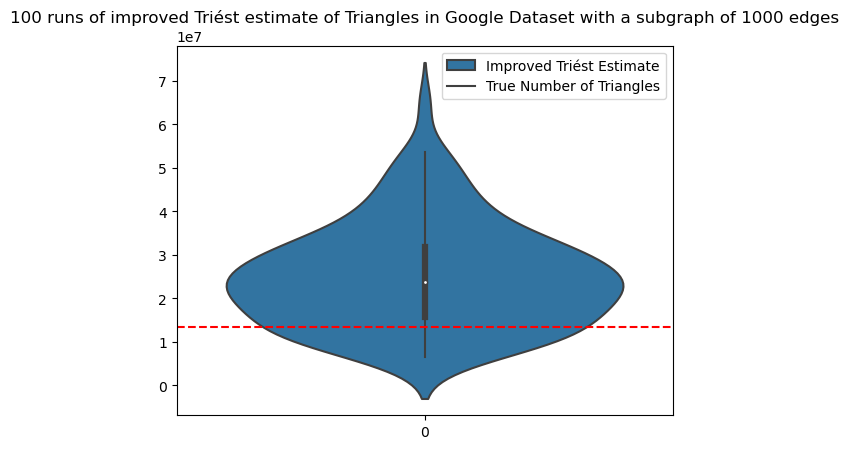

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(runs)
plt.axhline(y=NUMBER_OF_TRIANGLES, color='r', linestyle='--')
plt.legend(title='', loc='upper right', labels=['Improved Triést Estimate', 'True Number of Triangles']);
plt.title('100 runs of improved Triést estimate of Triangles in Google Dataset with a subgraph of 1000 edges');


According to the paper, the algorithm is able to estimate the exact number of triangles when $M \ge t$, and should still be accurate with $0.001\%$ of the stream edges (in this case, $5105$). Using $M=1000$ is a poor choice, but a necessity for this kind of benchmark running on one comptuer. The improved algorithm seem to have a tendancy to overshoot the number of triangles, and increasing $M$ would certainly improve the accuracy. 